## Forecasting taxi orders (Time series)

The taxi company provided historical data on bookings at airports.

**Goal**

It is necessary to predict the number of taxi orders for the next hour so that the company can attract more drivers during peak hours.

**Task**

The value of the RMSE metric on the test sample should be no more than 48.


*Data structure:*

- *datetime* - time of the orders
- *num_orders* - number of taxi orders at airports


# 1. Preparation 

Before analyzing and training the model, let's check what data is presented.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.dummy import DummyClassifier

from statsmodels.tsa.seasonal import seasonal_decompose

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
taxi.sort_index(inplace=True)
display(taxi.head())
print(taxi.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


The data is presented for the period from March 2018 to the end of August 2018.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB
None


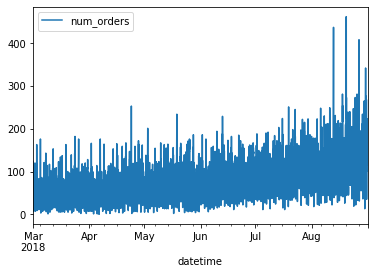

In [3]:
taxi = taxi.resample('1H').sum()
taxi.plot()
print(taxi.info())

The number of orders is gradually growing.

# 2. Analysis

Let's break the data down by day and look at trends in orders.

In [4]:
taxi_resample = taxi.resample('1D').sum()

In [7]:
def trend_seasonal_graph(data):
    decomposed = seasonal_decompose(data)
    plt.figure(figsize=(6, 8))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()


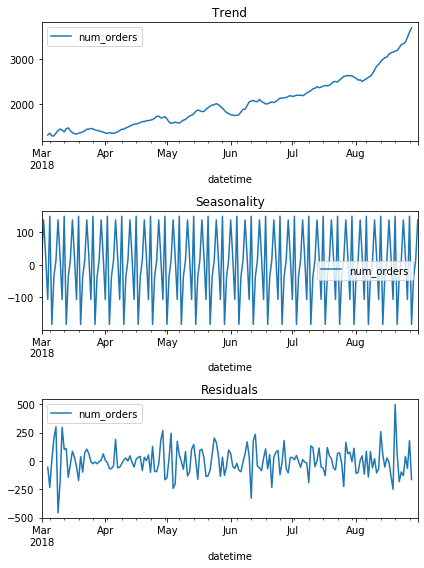

In [8]:
trend_seasonal_graph(taxi_resample)

*Trend*: The number of orders is growing, the company is doing well.

*Seasonal*: You can see the repeat period in the number of orders. For a more detailed consideration, we will separate the month and see what trends are visible there.

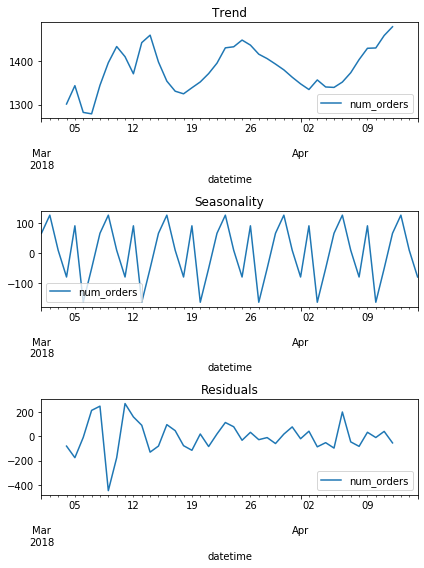

In [19]:
taxi_short = taxi_resample['2018-03-01':'2018-04-15']

trend_seasonal_graph(taxi_short)

Orders dropped on the 18th. Did the presidential election make a difference?

It can be seen that every week there is a repeatability. Consider separately a week and a day to identify dependencies there

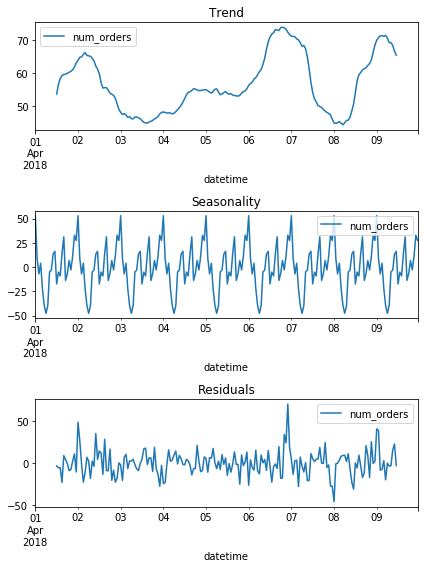

In [20]:
taxi_resample_hour = taxi.resample('1H').sum()
taxi_week = taxi_resample_hour['2018-04-01':'2018-04-09']

trend_seasonal_graph(taxi_week)

By the weekend, there is a gradual increase in the number of orders, and on Monday a sharp collapse

In [30]:
def trend_seasonal_graph_day(data):
    decomposed = seasonal_decompose(data)
    plt.figure(figsize=(6, 8))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.tight_layout()

Воскресенье:


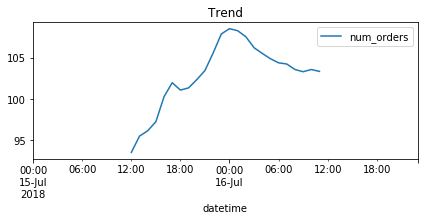

Пятница:


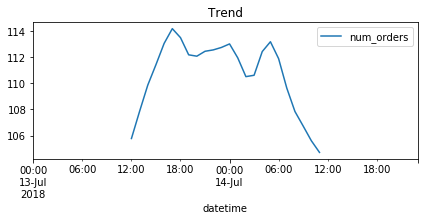

Среда:


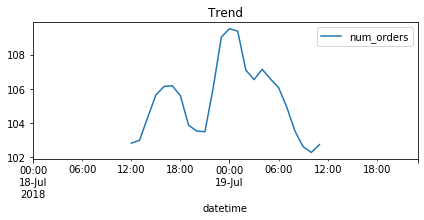

In [38]:
taxi_day_fri = taxi_resample_hour['2018-07-13':'2018-07-14']
taxi_day_sun = taxi_resample_hour['2018-07-15':'2018-07-16']
taxi_day_tue = taxi_resample_hour['2018-07-18':'2018-07-19']

print('Воскресенье:')
trend_seasonal_graph_day(taxi_day_sun)
plt.show()
print('Пятница:')
trend_seasonal_graph_day(taxi_day_fri)
plt.show()
print('Среда:')
trend_seasonal_graph_day(taxi_day_tue)

It can be seen from the graphs that, in general, the time-of-day trends are maintained for all days of the week. Demand begins to rise in the evening and persists until the morning, then falls during the working day

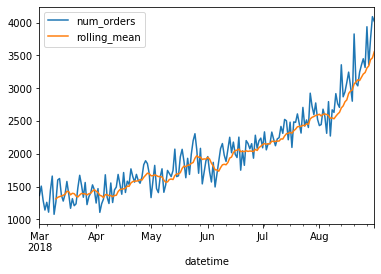

In [7]:
taxi_resample['rolling_mean'] = taxi_resample.rolling(10).mean()
taxi_resample.plot()

### Results

Analyzed the demand for a taxi to the airport in different time frames

In general, there is an increase in the number of orders over the entire period of time. By the weekend, demand increases, and on Monday there is a sharp collapse, the rest ends. During the day, a trend is also visible, people often leave in the evening and in the morning, but not during working hours.


# 3. Training

In [39]:
print(taxi.info())
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB
None


In [40]:
make_features(taxi, 6, 6)
display(taxi)
print(taxi.info())

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,172.666667
2018-08-31 20:00:00,154,2018,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,167.666667
2018-08-31 21:00:00,159,2018,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,171.166667


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 13 columns):
num_orders      4416 non-null int64
year            4416 non-null int64
month           4416 non-null int64
day             4416 non-null int64
dayofweek       4416 non-null int64
hour            4416 non-null int64
lag_1           4415 non-null float64
lag_2           4414 non-null float64
lag_3           4413 non-null float64
lag_4           4412 non-null float64
lag_5           4411 non-null float64
lag_6           4410 non-null float64
rolling_mean    4410 non-null float64
dtypes: float64(7), int64(6)
memory usage: 483.0 KB
None


Added temporary signs. Adjusted lag and moving average values

In [41]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train.dropna()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 06:00:00,12,2018,3,1,3,6,6.0,43.0,66.0,71.0,85.0,124.0,65.833333
2018-03-01 07:00:00,15,2018,3,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,47.166667
2018-03-01 08:00:00,34,2018,3,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,35.500000
2018-03-01 09:00:00,69,2018,3,1,3,9,34.0,15.0,12.0,6.0,43.0,66.0,29.333333
2018-03-01 10:00:00,64,2018,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,29.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,137,2018,8,13,0,9,91.0,39.0,66.0,83.0,143.0,168.0,98.333333
2018-08-13 10:00:00,156,2018,8,13,0,10,137.0,91.0,39.0,66.0,83.0,143.0,93.166667
2018-08-13 11:00:00,144,2018,8,13,0,11,156.0,137.0,91.0,39.0,66.0,83.0,95.333333


In [42]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [43]:
def rmse_func(target,pred):
    mse = mean_squared_error(target,pred)
    rmse = mse ** 0.5
    return rmse

rmse_score = make_scorer(rmse_func,greater_is_better=False)

In [59]:
def boost_func(features_train, target_train):
   

    tscv = TimeSeriesSplit(n_splits=3)
                    
    param_grid = {'depth': [1,2,3,4],
                  'learning_rate' : [0.03,0.3,1.0],
                  'n_estimators':[20,40,60,80]}
    

    gs = GridSearchCV(CatBoostRegressor(loss_function = 'RMSE'),cv=tscv, param_grid = param_grid,
                      scoring=rmse_score)
    
    gs.fit(features_train, target_train, verbose = False)
    
    score = {'model':'CatBoostRegressor', 'score' : gs.best_score_, 'param': gs.best_params_}
    
    return score

In [60]:
catboost_train = boost_func(features_train, target_train)

In [48]:
print(catboost_train)

{'model': 'CatBoostRegressor', 'score': -26.910337857798883, 'param': {'depth': 3, 'learning_rate': 0.3, 'n_estimators': 80}}


In [49]:
def lgbm_func(features_train, target_train):
    
    tscv = TimeSeriesSplit(n_splits=3)
                    

    param_grid = {'learning_rate': [0.03, 0.3, 1.0],
                  'n_estimators': [20, 40, 60,80],
                  'num_leaves': [2, 31, 50, 100]}

    gbm = GridSearchCV(LGBMRegressor(shuffle=False), param_grid=param_grid, cv=tscv, scoring=rmse_score)
    gbm.fit(features_train, target_train)
    score = {'model':'LGBMRegressor','parameters': gbm.best_params_,'score' : gbm.best_score_}
    return score

In [51]:
lgbm_train = lgbm_func(features_train, target_train)

In [52]:
print(lgbm_train)

{'model': 'LGBMRegressor', 'parameters': {'learning_rate': 0.3, 'n_estimators': 20, 'num_leaves': 50}, 'score': -27.78072077896797}


We selected hyperparameters for two models. Let's test both

# 4. Testing

Check the value on a constant model

In [53]:
dc_model = DummyClassifier(strategy='most_frequent')
dc_model.fit(features_train, target_train)
dummy_predictions = dc_model.predict(features_test)
dummy_mse = rmse_func(target_test, dummy_predictions)
print(dummy_mse)

88.64441651443998


In [54]:
cat_boost_model = CatBoostRegressor(loss_function = 'RMSE', depth=5,learning_rate=0.3,n_estimators=52)
cat_boost_model.fit(features_train,target_train, verbose=50)
predictions_test_cat = cat_boost_model.predict(features_test)

0:	learn: 33.9430187	total: 2.59ms	remaining: 132ms
50:	learn: 19.6697100	total: 697ms	remaining: 13.7ms
51:	learn: 19.6051005	total: 780ms	remaining: 0us


In [55]:
lgbm_model = LGBMRegressor(learning_rate=0.3,n_estimators=43,num_leaves=7)
lgbm_model.fit(features_train,target_train, eval_metric='rmse')
predictions_test_lgbm = lgbm_model.predict(features_test)

In [56]:
print('catboost rmse_score:',rmse_func(target_test, predictions_test_cat))
print('lgbmregressor rmse_score:',rmse_func(target_test, predictions_test_lgbm) )

catboost rmse_score: 45.507076703507074
lgbmregressor rmse_score: 44.188287126748634


Both models showed a good result rmse less than the constant and less than 48. But lgbm showed a better result, rmse = 44.19.

## The overall result

An analysis of the demand for taxis in different time frames was carried out. There is a trend of growth in the number of orders over the entire period of time.

Two models catboost and lgbm were trained, both solved the task and reached the rmse value less than 48.

In general, the model will be able to predict the taxi demand for the next hour.